In [1]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt
import warnings

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
df = pd.read_csv('1_1.csv',';', index_col=['date'],
                 parse_dates=['date'], dayfirst=True)
df.head()

,period,fact,prediction,prev
date,,,,
2010-01-11,Дек ' 09,0.4,NaN,0.3
2010-02-03,Янв ' 10,1.6,NaN,0.4
2010-03-04,Фев ' 10,0.9,NaN,01.июнь
2010-04-05,Мар ' 10,0.6,NaN,0.9
2010-05-05,Апр ' 10,0.3,0.5,0.6


In [29]:
df['fact'] = df['fact'].astype(float)

Посмотрим на данные

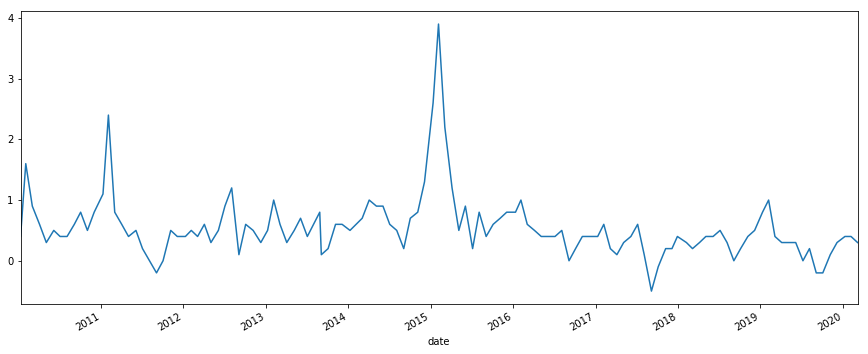

In [30]:
plt.figure(figsize(15,6))
df['fact'].plot()
plt.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p = 2.0269228702654347e-05


<Figure size 864x720 with 0 Axes>

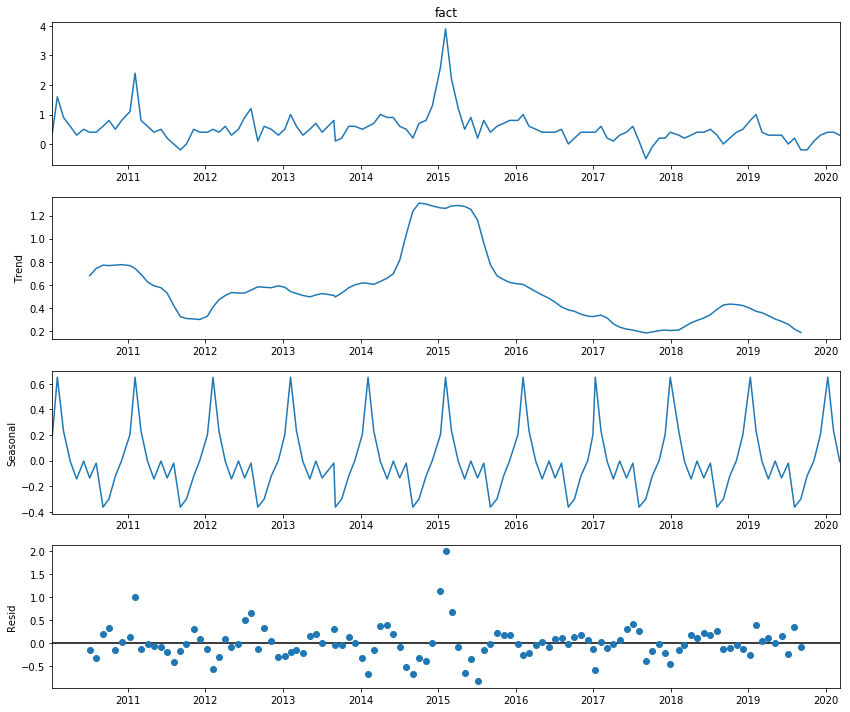

In [31]:
plt.figure(figsize(12,10))
sm.tsa.seasonal_decompose(df['fact'], period=12).plot()
print(f"Критерий Дики-Фуллера: p = {sm.tsa.stattools.adfuller(df['fact'], maxlag=14)[1]}")

Хоть и $p-value$ < 0.05 - уровня значимости $\alpha$, явно виден тренд, который в основном сначала растет, потом убывает, что свидетельствует, вообще говоря, против его стационарности, поэтому сделаем дифференицрование

Критерий Дики-Фуллера: p = 3.62320768280988e-08


<Figure size 864x720 with 0 Axes>

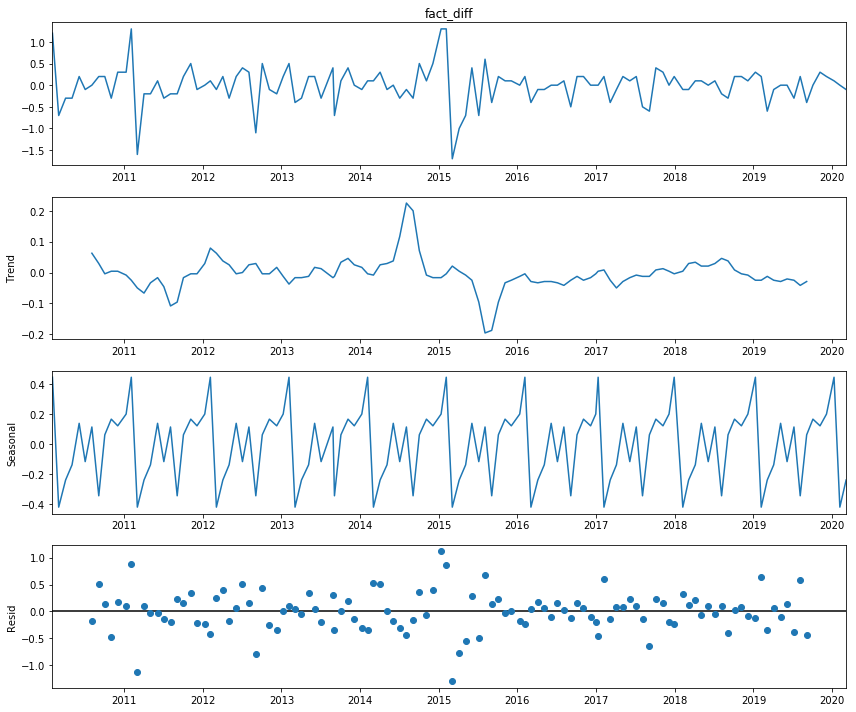

In [32]:
df['fact_diff'] = df['fact'] - df['fact'].shift(1)
plt.figure(figsize(12,10))
sm.tsa.seasonal_decompose(df['fact_diff'][1:], period=12).plot()
print(f"Критерий Дики-Фуллера: p = {sm.tsa.stattools.adfuller(df['fact_diff'][1:])[1]}")

Посмотрим на сами преобразованные данные

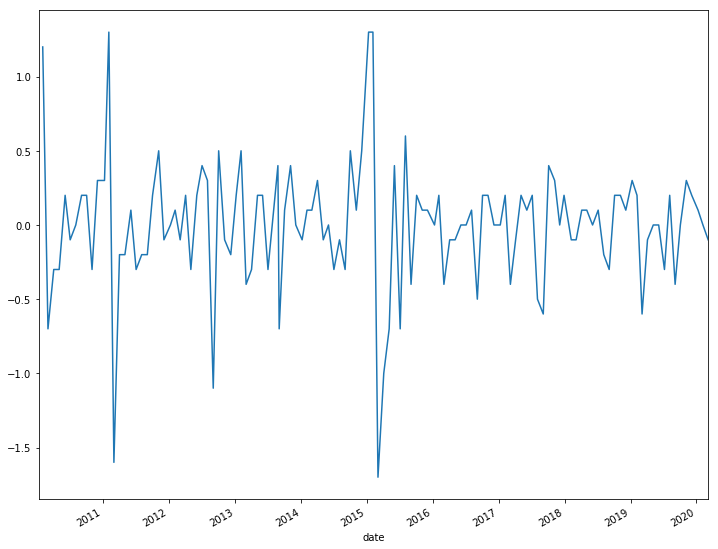

In [33]:
plt.figure(figsize(12,10))
df['fact_diff'].plot()

Заметно, что стало лучше, и ряд уже похож на стационарный, что подтверждает критерий Дики-Фуллера

Гипотеза нестационарности отвергается, то есть получили стационарный ряд. Визуально ряд выглядит лучше

## Подбор модели
Посмотрим на ACF и PACF полученного ряда:

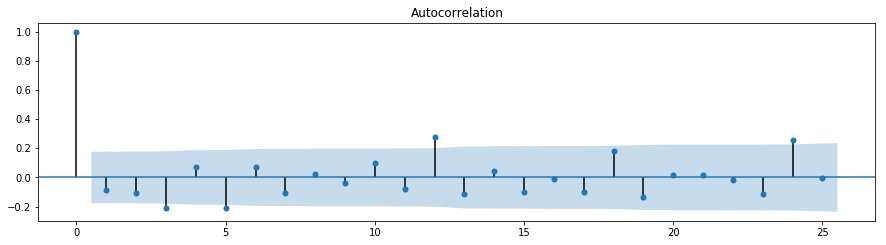

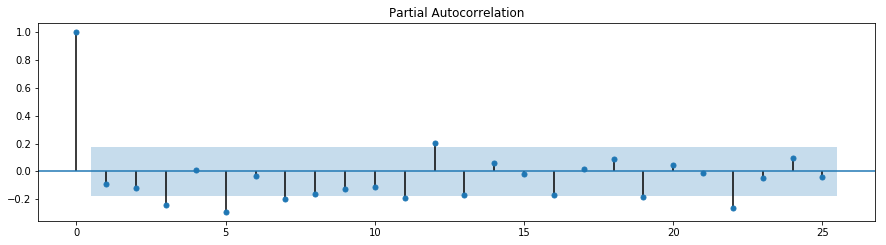

In [34]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['fact_diff'][1:].values.squeeze(), lags=25, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['fact_diff'][1:].values.squeeze(), lags=25, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=5, P=1, p=5, d=1, D=0

Составим различные комбинации, исходя из начального приближения

In [14]:
ps = range(0, 6)
ds = 1
qs = range(0, 6)
Ps = range(0, 2)
Ds = 0
Qs = range(0, 2)

In [16]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

Переберем все комбинации и отсортируем по критерию Акаике. Чем меньше его значение, тем лучше модель

In [19]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(df['fact'], order=(param[0], ds, param[1]), 
                                          seasonal_order=(param[2], Ds, param[3], 12)).fit(disp=False,
                                                                                           maxiter=1000)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param[0], ds, param[1], param[2], Ds, param[3], model.aic])
    
warnings.filterwarnings('default')

 Выведем топ-5 моделей

In [20]:
result_table = pd.DataFrame(results, columns=['p', 'd', 'q', 'P', 'D', 'Q', 'aic'])
print(result_table.sort_values(by = 'aic', ascending=True).head())

     p  d  q  P  D  Q         aic
115  4  1  4  1  0  1  115.039437
23   0  1  5  1  0  1  115.150992
47   1  1  5  1  0  1  116.029965
15   0  1  3  1  0  1  116.599022
91   3  1  4  1  0  1  116.714492


Выведем некоторую статистику по лучшей модели

In [21]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 fact   No. Observations:                  124
Model:             SARIMAX(4, 1, 4)x(1, 0, [1], 12)   Log Likelihood                 -46.520
Date:                              Sun, 29 Mar 2020   AIC                            115.039
Time:                                      21:03:19   BIC                            145.973
Sample:                                           0   HQIC                           127.605
                                              - 124                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2438      0.127     -9.815      0.000      -1.492      -0.995
ar.L2         -0.46

Критерий Льюинга-Бокса проверяет гипотезу о некоррелированности остатков,
из полученной статистики видно, что на уровне значимости $\alpha$ = 0.05 гипотеза не отвергается, а значит остатки некоррелированы. Убедимся в этом также визуально на ACF графике и посмотрим на график остатков непосредстенно

Критерий Стьюдента: p = 0.5674687578461938
Критерий Дики-Фуллера: p = 4.132439329850335e-21


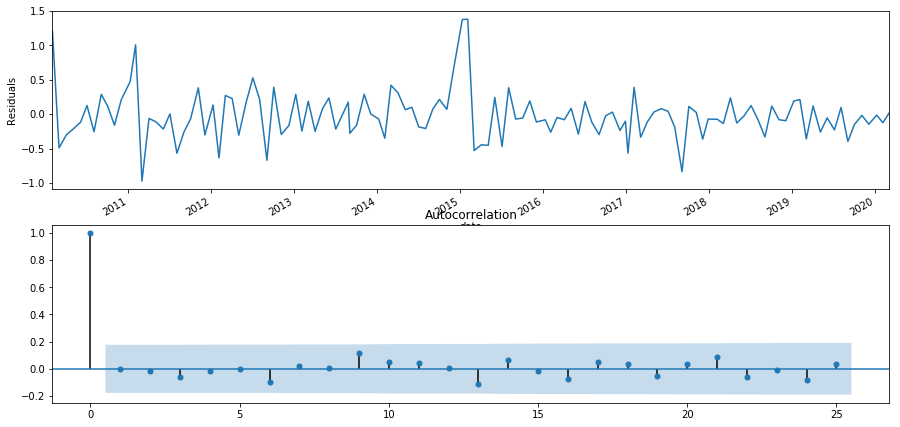

In [48]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[1:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze(), lags=25, ax=ax)

print(f"Критерий Стьюдента: p = {stats.ttest_1samp(best_model.resid[1:], 0)[1]}")
print(f"Критерий Дики-Фуллера: p = {sm.tsa.stattools.adfuller(best_model.resid[1:])[1]}")

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

In [ ]:
best_model = sm.tsa.statespace.SARIMAX(df['fact'], order=(2, 1, 1)).fit(disp=False, maxiter=1000)

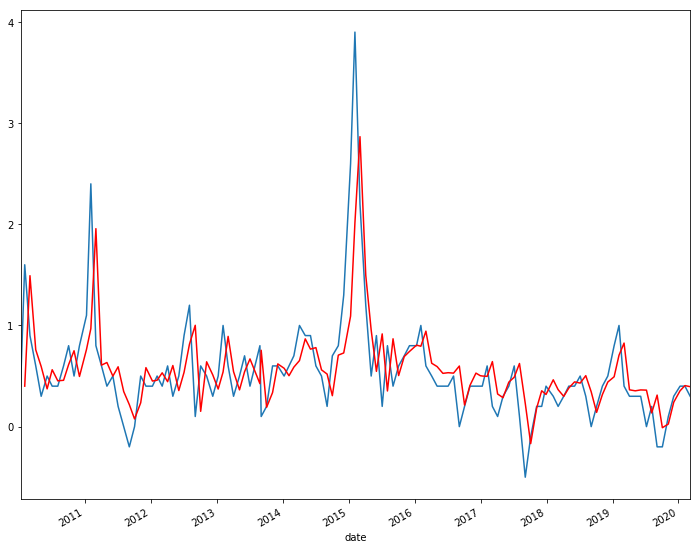

In [55]:
df['model'] = best_model.fittedvalues
plt.figure(figsize(12,10))
df['fact'].plot()
df.model[1:].plot(color='r')
pylab.show()

Видно, что модель и данные достаточно хорошо похожи друг на друга.

Исходя из вышесказанного, получаем что модель SARIMA(3, 1, 3)x(0, 1, 1, 12) весьма хорошо подходит под имеющиеся данные, но, думаю, что могло быть лучше если бы производилась стабилизия дисперсии, например, методом Бокса-Кокса